# Libraries

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb 20 18:46:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!git clone https://github.com/facebookresearch/detr.git
!pip install pydicom

import pydicom
import torchvision
import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim.lr_scheduler import StepLR

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS########################
import sys
sys.path.append('/content/detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion
from detr.models.detr import PostProcess
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from albumentations.pytorch.transforms import ToTensorV2
from torchvision import transforms

#Glob
from glob import glob

from google.colab import drive
drive.mount('/content/drive')

!unzip drive/MyDrive/INBreast_detr.zip

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Cloning into 'detr'...
remote: Enumerating objects: 263, done.
remote: Total 263 (delta 0), reused 0 (delta 0), pack-reused 263
Receiving objects: 100% (263/263), 12.88 MiB | 18.41 MiB/s, done.
Resolving deltas: 100% (122/122), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.6 MB/s eta 0:00:00
Mounted at /content/drive
Archive:  drive/MyDrive/INBreast_detr.zip
   creating: INBreast_detr/test/
  inflating: INBreast_detr/test/30011507_349323117bf0fd93_MG_L_CC_ANON.dcm  
  inflating: INBreast_detr/test/30011553_349323117bf0fd93_MG_L_ML_ANON.dcm  
  inflating: INBreast_detr/test/30011674_6968748e66837bc7_MG_L_CC_ANON.dcm  
  inflating: INBreast_detr/test/30011727_6968748e66837bc7_MG_L_ML_ANON.dcm  
  inflating: INBreast_detr/test/50994273_cc9e66c5b31baab8_MG_R_CC_ANON.dcm  
  inflating: INBreast_detr/test/50994354_cc9e66c5b31baab8_MG_R_ML_ANON.dcm  
  inflating: INBreast_detr/test/50994408_cc9e66c5b31baab8_MG_R_CC_ANON.dcm  
  inflating: INBreast_detr/test/50995762_0c735e

#Custom dataset i dataloader


In [ ]:
bboxes = pd.read_csv('/content/drive/MyDrive/normalized_bboxes.csv')

#lista naziva slika koje su u train-u, val-u i test-u
train_path = '/content/INBreast_detr/train/'
train_file_names = np.array(os.listdir(train_path))

val_path = '/content/INBreast_detr/val/'
val_file_names = np.array(os.listdir(val_path))

test_path = '/content/INBreast_detr/test/'
test_file_names = np.array(os.listdir(test_path))

print(len(train_file_names))
print(len(val_file_names))
print(len(test_file_names))

75
17
15


In [ ]:
#dataset parameters
BATCH_SIZE = 4
width=1333
height=800

In [ ]:
class INBreastDataset(Dataset):
    def __init__(self, path, dataframe, transforms=None):
        self.path = path
        self.df = dataframe
        self.transforms = transforms
        self.file_names = np.array(os.listdir(path))

    def __len__(self) -> int:
        return self.file_names.shape[0]

    def __getitem__(self,index):
        image_id = self.file_names[index]
        records = self.df[self.df['image_id'] == image_id] #kolona iz marking za odgoravajucu sliku

        img = pydicom.dcmread(self.path+image_id) #ucitavanje odgovarajuce slike
        img = img.pixel_array
        image = np.stack((img, img, img), axis=2)

        bboxes = records[['x', 'y', 'w', 'h']].values
        class_labels = np.zeros(len(bboxes))

        if self.transforms:
          transformed = self.transforms(image=image, bboxes=bboxes, class_labels=class_labels)

        transf_image = transformed['image']

        target = {}
        #boxes moraju biti u formatu: (center_x, center_y, width, height)
        target['boxes'] = torch.as_tensor(transformed['bboxes'],dtype=torch.float32)
        target['labels'] = torch.as_tensor(transformed['class_labels'],dtype=torch.long)

        return transf_image, target

In [ ]:
train_transform = A.Compose([
    A.Resize(width=width, height=height),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

val_transform = A.Compose([
    A.Resize(width=width, height= height),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

test_transform = A.Compose([
    A.Resize(width=width, height=height),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

In [ ]:
train_dataset = INBreastDataset(train_path, dataframe=bboxes, transforms=train_transform)
val_dataset = INBreastDataset(val_path, dataframe=bboxes, transforms=val_transform)
test_dataset = INBreastDataset(test_path, dataframe=bboxes, transforms=test_transform)

In [ ]:
def collate_fn(batch):
#slike se moraju prosledjivati modelu u obliku u kom je ulaz u model - [batch size, C, H, W]
#bboxevi treba da budu u istom obliku kao izlaz iz modela
    images, bboxes = zip(*batch)

    return torch.stack(images, dim=0), list(bboxes)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

print(len(train_dataloader)) #18 batcheva po 4 slike i jedan batch sa 3 slike -> 75=18*4+3
print(len(val_dataloader)) #4 batcha po 4 slike i jedan batch sa jednom slikom -> 17=4*4+1
print(len(test_dataloader)) #3 batcha sa po 4 slika i jedan batch sa 3 slike -> 15=3*4+3

75
17
15
19
5
4


In [ ]:
for batch in train_dataloader:
  images, bboxess = batch
  print(images.shape)
  print(images[0].shape)
  print(len(bboxess))
  print(bboxess[0])
  break

torch.Size([4, 3, 800, 1333])
torch.Size([3, 800, 1333])
4
{'boxes': tensor([[0.6430, 0.4691, 0.1623, 0.1033]]), 'labels': tensor([0])}


# Data Analysis

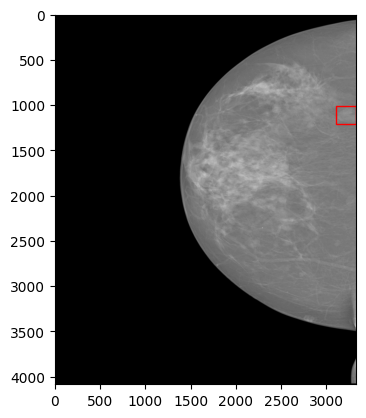

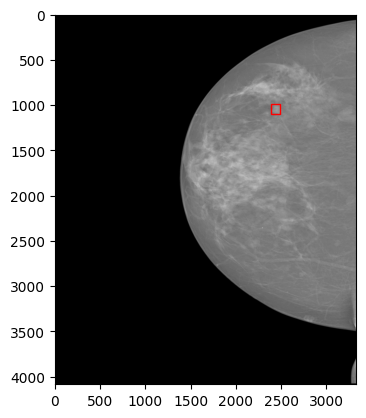

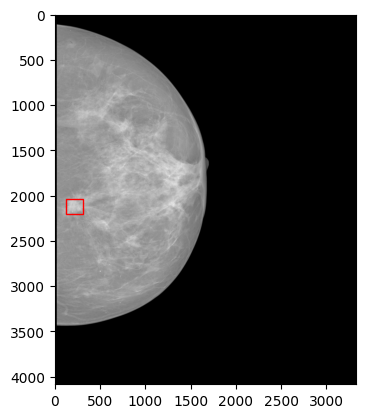

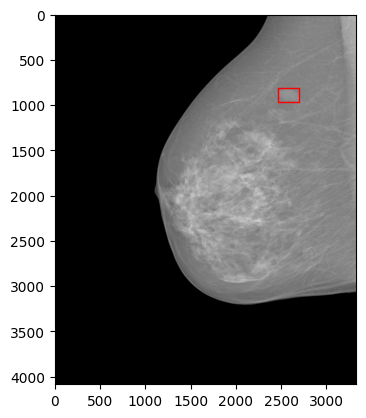

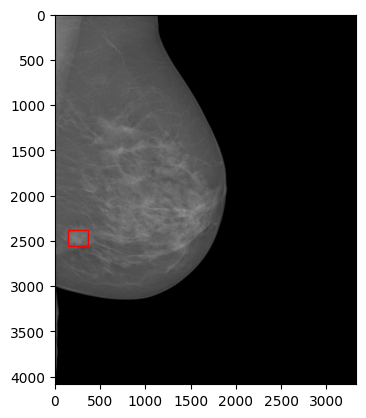

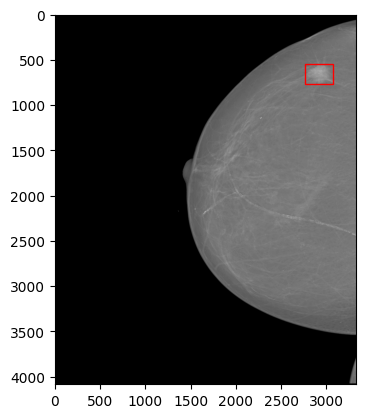

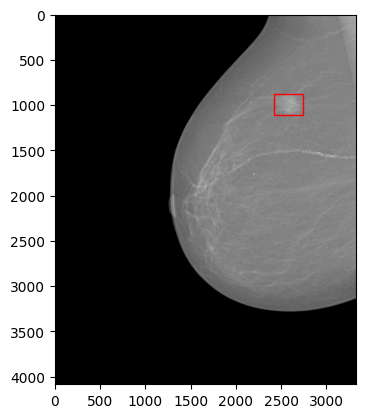

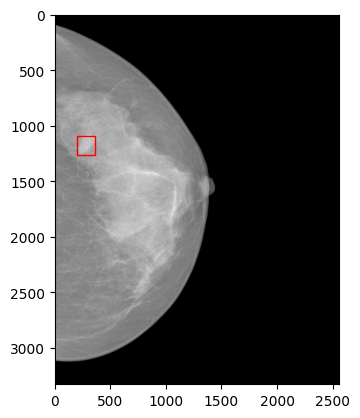

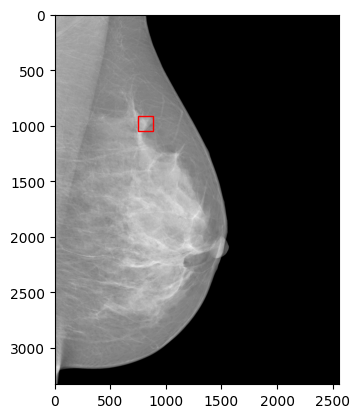

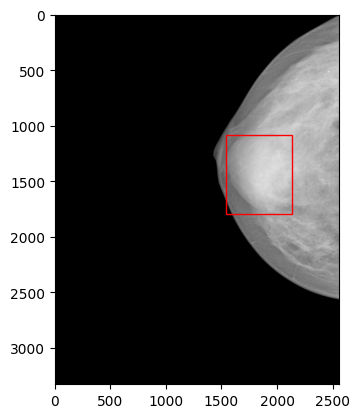

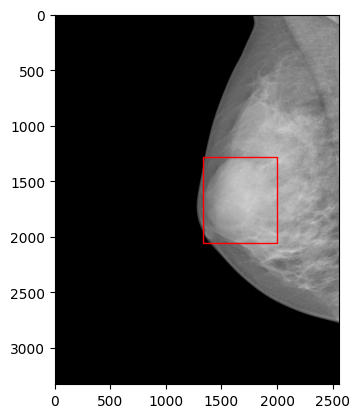

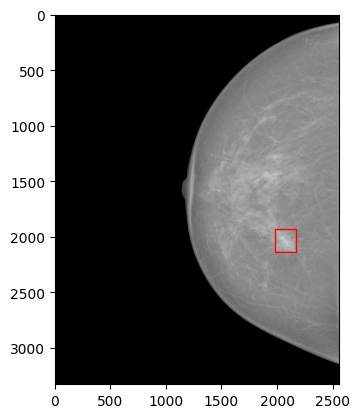

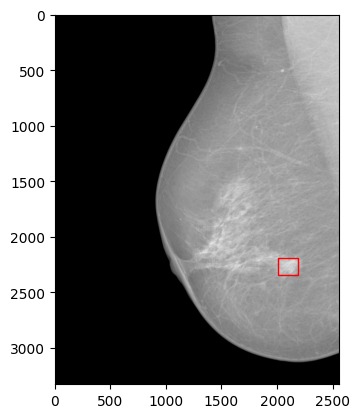

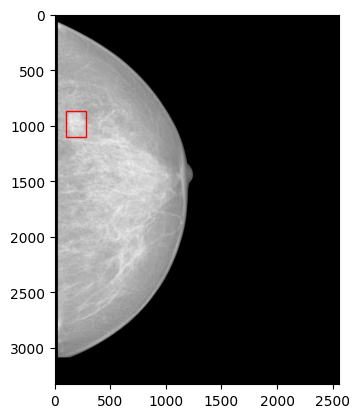

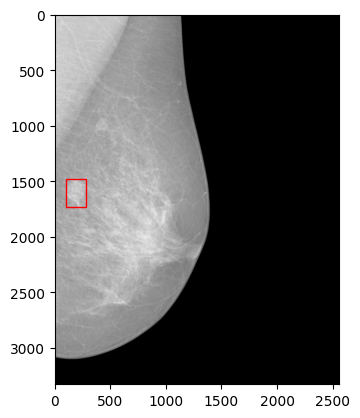

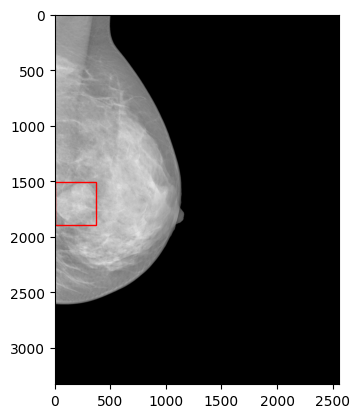

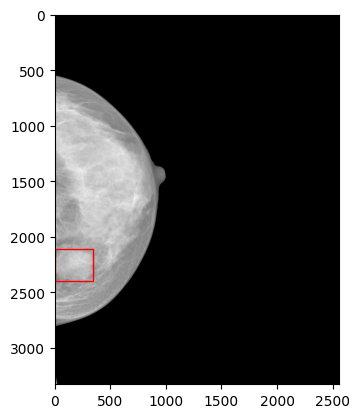

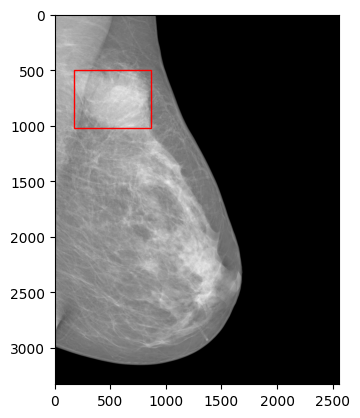

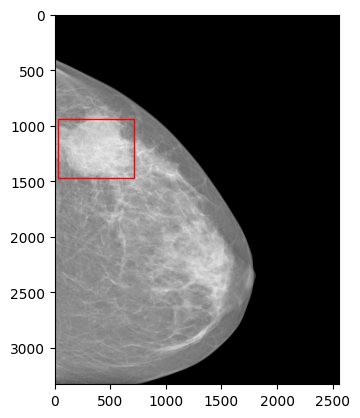

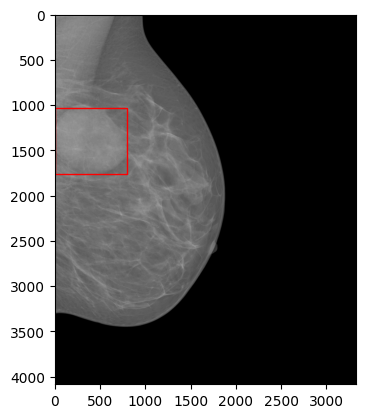

In [ ]:
i = 0
for norm_cx, norm_cy, norm_w, norm_h, img_path in zip(bboxes['x'], bboxes['y'], bboxes['w'], bboxes['h'], bboxes['image_id']):
    # Učitavanje DICOM slike
    img = pydicom.dcmread(os.path.join(train_path, img_path))
    original_img = img.pixel_array
    img_height, img_width = original_img.shape[:2]

    # Prikazivanje originalne slike
    plt.imshow(original_img, cmap='gray')

    # Pretvaranje u apsolutne koordinate
    cx = int(norm_cx * img_width)
    cy = int(norm_cy * img_height)
    w = int(norm_w * img_width)
    h = int(norm_h * img_height)

    # Izračunavanje gornjeg levog ugla bounding box-a
    x = int(cx - w / 2)
    y = int(cy - h / 2)

    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

    plt.show()

    i += 1
    if i == 20:
        break

In [ ]:
for data in test_dataloader:
    images, target = data
    print(len(images))
    print(len(target))
    for img, target in zip(images, target):
        print(target)
        transformed_image = img.permute(1, 2, 0)
        print(transformed_image)
        transformed_image = (transformed_image - transformed_image.min()) / (transformed_image.max() - transformed_image.min())
        plt.imshow(transformed_image, cmap='gray')

        cx = int(target['boxes'][0][0] * img.shape[2])
        cy = int(target['boxes'][0][1]  * img.shape[1])
        w = int(target['boxes'][0][2]  * img.shape[2])
        h = int(target['boxes'][0][3]  * img.shape[1])

        x = int(cx - w / 2)
        y = int(cy - h / 2)
        print(x)
        print(y)
        print(w)
        print(h)
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

        plt.show()
        break

In [ ]:
idx = 70
image, target = train_dataset[idx]
print(image.min())
print(image.max())
print(image.shape)
print(target)
transformed_image = image.permute(1, 2, 0) #samo za prikaz
transformed_image = (transformed_image - transformed_image.min()) / (transformed_image.max() - transformed_image.min()) #stavljanje vrednosti od 0 do 1 samo za prikaz
plt.imshow(transformed_image, cmap='gray')

# Pretvaranje natrag u apsolutne koordinate
cx = int(target['boxes'][0][0] * image.shape[2])
cy = int(target['boxes'][0][1]  * image.shape[1])
w = int(target['boxes'][0][2]  * image.shape[2])
h = int(target['boxes'][0][3]  * image.shape[1])

# Izračunavanje gornjeg levog ugla bounding box-a
x = int(cx - w / 2)
y = int(cy - h / 2)
print(x)
print(y)
print(w)
print(h)

rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

plt.show()

In [ ]:
idx = 70
image, target = train_dataset[idx] #image ima i negativne vrednosti
print(image.min())
print(image.max())
print(image.shape)
print(target)
transformed_image = image.permute(1, 2, 0) #samo za prikaz
transformed_image = (transformed_image - transformed_image.min()) / (transformed_image.max() - transformed_image.min()) #stavljanje vrednosti od 0 do 1 samo za prikaz
plt.imshow(transformed_image, cmap='gray')

# Pretvaranje natrag u apsolutne koordinate
cx = int(target['boxes'][0][0] * image.shape[2])
cy = int(target['boxes'][0][1]  * image.shape[1])
w = int(target['boxes'][0][2]  * image.shape[2])
h = int(target['boxes'][0][3]  * image.shape[1])

# Izračunavanje gornjeg levog ugla bounding box-a
x = int(cx - w / 2)
y = int(cy - h / 2)
print(x)
print(y)
print(w)
print(h)

rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

plt.show()

# Model Analysis

Ulaz u model:
torch.Size([1, 3, 3328, 2560]) - [batch size, C, H, W]

In [ ]:
from torchvision.models import resnet50

In [ ]:
class DETR(nn.Module):
  def __init__(self, num_classes, num_queries, hidden_dim, nheads, num_encoder_layers, num_decoder_layers):
    super().__init__()
    self.backbone = nn.Sequential(*list(resnet50(pretrained=True).children())[:-2])
    self.conv = nn.Conv2d(2048, hidden_dim, 1)
    self.transformer = nn.Transformer(hidden_dim, nheads,
    num_encoder_layers, num_decoder_layers)
    self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
    self.linear_bbox = nn.Linear(hidden_dim, 4)
    self.query_pos = nn.Parameter(torch.rand(num_queries, hidden_dim)) #pre obuke je sve rand (vektor koji ulazi u dekoder)
    self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2)) #2 vektora (matrice) koja ulaze u encoder su u pocetku takodje rand
    self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2)) #ova 2 vektora koja ulaze u encoder kada izadju iz njega ostaju iste dimenzije
    #samo im se doda attention i zatim oni predstavljaju side input u dekoder

  def forward(self, inputs):
    x = self.backbone(inputs)
    h = self.conv(x)
    d, H, W = h.shape[-3:]

    pos = torch.cat([
    self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
    self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),], dim=-1).flatten(0, 1).unsqueeze(1)

    #ovaj deo sam prosirila u odnosu na model iz rada kako bi mogao da se koristi batch za obuku
    batch_size = h.shape[0]
    query_pos_repeated = self.query_pos.unsqueeze(1).repeat(1, batch_size, 1)
    pos_repeated = pos.repeat(1, batch_size, 1)
    h_t = self.transformer(pos_repeated + h.flatten(2).permute(2, 0, 1), query_pos_repeated)

    output = {}
    output['pred_logits'] = self.linear_class(h_t)
    output['pred_boxes'] = self.linear_bbox(h_t).sigmoid() #sigmoid sve vrednosti preslikava od 0 do 1 (pre sigmoida su bile i negativne vrednosti a posle su sve u opsegu od 0 do 1)

    return x, h, d, H, W, self.col_embed, self.row_embed, self.query_pos, h_t, output  #output #drugacije su dimenzije nego u prethodnom

In [ ]:
print(image.shape)
print(image.unsqueeze(0).shape)
print(image.unsqueeze(1).shape)
print(image.unsqueeze(2).shape)
print(image.unsqueeze(3).shape)

torch.Size([3, 800, 1333])
torch.Size([1, 3, 800, 1333])
torch.Size([3, 1, 800, 1333])
torch.Size([3, 800, 1, 1333])
torch.Size([3, 800, 1333, 1])


Provera izlaza iz svakog bloka za batch size = 1

In [ ]:
detr = DETR(num_classes=1, num_queries=10, hidden_dim=256, nheads=8, num_encoder_layers=6, num_decoder_layers=6)
detr.eval()
inputs = image.unsqueeze(0) #torch.randn(1, 3, 800, 1200) (unsqueeze(0) ovo mi treba samo kad ubacujem jednu sliku jer mora po batchu da se ubacuje)
# print(inputs.shape)
# logits, bboxes = detr(inputs)
# print(logits.shape) #[num_queries, batch_size, num_classes+1]
# print(bboxes.shape) #[num_queries, batch_size, 4]
x, h, d, H, W, col_embed, row_embed, query_pos, h_t, output  = detr(inputs)
# print(output['pred_logits'].shape) #[batch_size, num_queries, num_classes]
# print(output['pred_boxes'].shape)
# print(output)
print('ulaz u model (batch, 3 channels, W0, H0):', inputs.shape)
print('izlaz iz backbone-a (batch, C channels, W0/32, H0/32):', x.shape)
print('new feature map (batch, d, W, H):', h.shape)
print('d: ', d)
print('H:', H)
print('W:', W)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batc

ulaz u model (batch, 3 channels, W0, H0): torch.Size([1, 3, 800, 1333])
izlaz iz backbone-a (batch, C channels, W0/32, H0/32): torch.Size([1, 2048, 25, 42])
new feature map (batch, d, W, H): torch.Size([1, 256, 25, 42])
d:  256
H: 25
W: 42


In [ ]:
#print('col_embed', col_embed)
print('col_embed.shape, (50, hidden_dim // 2):', col_embed.shape)
print('col_embed[:W]: ', col_embed[:W].shape)
print('col_embed[:W].unsqueeze(0): ', col_embed[:W].unsqueeze(0).shape)
col_final = col_embed[:W].unsqueeze(0).repeat(H, 1, 1)
print('col_embed[:W].unsqueeze(0).repeat(H, 1, 1): ', col_final.shape)

col_embed.shape, (50, hidden_dim // 2): torch.Size([50, 128])
col_embed[:W]:  torch.Size([42, 128])
col_embed[:W].unsqueeze(0):  torch.Size([1, 42, 128])
col_embed[:W].unsqueeze(0).repeat(H, 1, 1):  torch.Size([25, 42, 128])


In [ ]:
#print('row_embed', row_embed)
print('row_embed.shape, (50, hidden_dim // 2):', row_embed.shape)
print('row_embed[:H]: ', row_embed[:H].shape)
print('row_embed[:H].unsqueeze(1): ', row_embed[:H].unsqueeze(1).shape)
row_final = row_embed[:H].unsqueeze(1).repeat(1, W, 1)
print('row_embed[:H].unsqueeze(1).repeat(1, W, 1): ', row_final.shape)

row_embed.shape, (50, hidden_dim // 2): torch.Size([50, 128])
row_embed[:H]:  torch.Size([25, 128])
row_embed[:H].unsqueeze(1):  torch.Size([25, 1, 128])
row_embed[:H].unsqueeze(1).repeat(1, W, 1):  torch.Size([25, 42, 128])


In [ ]:
print('cat: ', torch.cat([col_final, row_final], dim=-1).shape)
print('flatten(0, 1): ', torch.cat([col_final, row_final], dim=-1).flatten(0, 1).shape)
print('unsqueeze(1): ', torch.cat([col_final, row_final], dim=-1).flatten(0, 1).unsqueeze(1).shape)

cat:  torch.Size([25, 42, 256])
flatten(0, 1):  torch.Size([1050, 256])
unsqueeze(1):  torch.Size([1050, 1, 256])


In [ ]:
batch_size = h.shape[0]
print('batch_size', batch_size)
pos = torch.cat([col_final, row_final], dim=-1).flatten(0, 1).unsqueeze(1)
print('pos: ', pos.shape)
print('pos.repeat(1, batch_size, 1)', pos.repeat(1, batch_size, 1).shape)

print('h.flatten(2): ', h.flatten(2).shape) #h: torch.Size([1, 256, 25, 38])
print('h.flatten(2).permute(2, 0, 1): ', h.flatten(2).permute(2, 0, 1).shape)
print('pos.repeat(1, batch_size, 1) + h.flatten(2).permute(2, 0, 1), prvi ulaz u transformer: ', (pos.repeat(1, batch_size, 1) + h.flatten(2).permute(2, 0, 1)).shape)
print('query_pos, (num_queries, hidden_dim) : ', query_pos.shape)
print('query_pos.unsqueeze(1): ', query_pos.unsqueeze(1).shape)
print('query_pos.unsqueeze(1).repeat(1, batch_size, 1), drugi ulaz u transformer: ', query_pos.unsqueeze(1).repeat(1, batch_size, 1).shape)
print('izlaz iz transformera: ', h_t.shape)

batch_size 1
pos:  torch.Size([1050, 1, 256])
pos.repeat(1, batch_size, 1) torch.Size([1050, 1, 256])
h.flatten(2):  torch.Size([1, 256, 1050])
h.flatten(2).permute(2, 0, 1):  torch.Size([1050, 1, 256])
pos.repeat(1, batch_size, 1) + h.flatten(2).permute(2, 0, 1), prvi ulaz u transformer:  torch.Size([1050, 1, 256])
query_pos, (num_queries, hidden_dim) :  torch.Size([10, 256])
query_pos.unsqueeze(1):  torch.Size([10, 1, 256])
query_pos.unsqueeze(1).repeat(1, batch_size, 1), drugi ulaz u transformer:  torch.Size([10, 1, 256])
izlaz iz transformera:  torch.Size([10, 1, 256])


In [ ]:
print(pos.shape)
print(pos.repeat(1, 2, 1).shape)

torch.Size([1050, 1, 256])
torch.Size([1050, 2, 256])


In [ ]:
print('prvi izlaz iz celog modela (verovatnoce klasa): ', output['pred_logits'].shape) #[batch_size, num_queries, num_classes]
print('drugi izlaz iz celog modela (bbox za svako predvidjanje): ', output['pred_boxes'].shape)
print('izlaz iz modela', output)

prvi izlaz iz celog modela (verovatnoce klasa):  torch.Size([10, 1, 2])
drugi izlaz iz celog modela (bbox za svako predvidjanje):  torch.Size([10, 1, 4])
izlaz iz modela {'pred_logits': tensor([[[ 0.0972, -0.5968]],

        [[ 0.1219, -0.5471]],

        [[ 0.1323, -0.5397]],

        [[ 0.0985, -0.5074]],

        [[ 0.1231, -0.5743]],

        [[ 0.1321, -0.5610]],

        [[ 0.1530, -0.5225]],

        [[ 0.1368, -0.6074]],

        [[ 0.1482, -0.5699]],

        [[ 0.1250, -0.5621]]], grad_fn=<ViewBackward0>), 'pred_boxes': tensor([[[0.7784, 0.5227, 0.4451, 0.3967]],

        [[0.7747, 0.5048, 0.4700, 0.3825]],

        [[0.7860, 0.5105, 0.4625, 0.3953]],

        [[0.7833, 0.5085, 0.4650, 0.3926]],

        [[0.7931, 0.5137, 0.4669, 0.3878]],

        [[0.7827, 0.5217, 0.4472, 0.3871]],

        [[0.7814, 0.5187, 0.4793, 0.3959]],

        [[0.7779, 0.5123, 0.4626, 0.3920]],

        [[0.7944, 0.5187, 0.4661, 0.3818]],

        [[0.7856, 0.5216, 0.4629, 0.3924]]], grad_fn=<Sigmo

Provera izlaza iz svakog bloka za batch size = 2

In [ ]:
for batch in train_dataloader:
  print(batch)
  break

(tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [15.0411, 15.1610, 15.0925,  ..., -2.1179, -2.1179, -2.1179],
          [14.9897, 15.0069, 14.7500,  ..., -2.1179, -2.1179, -2.1179],
          [14.7329, 14.2705, 14.7329,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [15.5063, 15.6288, 15.5588,  ..., -2.0357, -2.0357, -2.0357],
          [15.4538, 15.4713, 15.2087,  ..., -2.0357, -2.0357, -2.0357],
          [15.1912, 14.7185, 15.1912,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, 

In [ ]:
detr = DETR(num_classes=1, num_queries=10, hidden_dim=256, nheads=8, num_encoder_layers=6, num_decoder_layers=6)
detr.eval()

for images, targets in train_dataloader:
  x, h, d, H, W, col_embed, row_embed, query_pos, h_t, output = detr(images)
  print('ulaz u model (batch, 3 channels, W0, H0):', images.shape)
  print('izlaz iz backbone-a (batch, C channels, W0/32, H0/32):', x.shape)
  print('new feature map (batch, d, W, H):', h.shape)
  print('d: ', d)
  print('H:', H)
  print('W:', W)

  #print('col_embed', col_embed)
  print('col_embed.shape, (50, hidden_dim // 2):', col_embed.shape)
  print('col_embed[:W]: ', col_embed[:W].shape)
  print('col_embed[:W].unsqueeze(0): ', col_embed[:W].unsqueeze(0).shape)
  col_final = col_embed[:W].unsqueeze(0).repeat(H, 1, 1)
  print('col_embed[:W].unsqueeze(0).repeat(H, 1, 1): ', col_final.shape)

  #print('row_embed', row_embed)
  print('row_embed.shape, (50, hidden_dim // 2):', row_embed.shape)
  print('row_embed[:H]: ', row_embed[:H].shape)
  print('row_embed[:H].unsqueeze(1): ', row_embed[:H].unsqueeze(1).shape)
  row_final = row_embed[:H].unsqueeze(1).repeat(1, W, 1)
  print('row_embed[:H].unsqueeze(1).repeat(1, W, 1): ', row_final.shape)

  print('cat: ', torch.cat([col_final, row_final], dim=-1).shape)
  print('flatten(0, 1): ', torch.cat([col_final, row_final], dim=-1).flatten(0, 1).shape)
  print('unsqueeze(1): ', torch.cat([col_final, row_final], dim=-1).flatten(0, 1).unsqueeze(1).shape)

  batch_size = h.shape[0]
  print('batch_size', batch_size)
  pos = torch.cat([col_final, row_final], dim=-1).flatten(0, 1).unsqueeze(1)
  print('pos: ', pos.shape)
  print('pos.repeat(1, batch_size, 1)', pos.repeat(1, batch_size, 1).shape)

  print('h.flatten(2): ', h.flatten(2).shape) #h: torch.Size([1, 256, 25, 38])
  print('h.flatten(2).permute(2, 0, 1): ', h.flatten(2).permute(2, 0, 1).shape)
  print('pos.repeat(1, batch_size, 1) + h.flatten(2).permute(2, 0, 1), prvi ulaz u transformer: ', (pos.repeat(1, batch_size, 1) + h.flatten(2).permute(2, 0, 1)).shape)
  print('query_pos, (num_queries, hidden_dim) : ', query_pos.shape)
  print('query_pos.unsqueeze(1): ', query_pos.unsqueeze(1).shape)
  print('query_pos.unsqueeze(1).repeat(1, batch_size, 1), drugi ulaz u transformer: ', query_pos.unsqueeze(1).repeat(1, batch_size, 1).shape)
  print('izlaz iz transformera: ', h_t.shape)

  print('prvi izlaz iz celog modela (verovatnoce klasa): ', output['pred_logits'].shape) #[batch_size, num_queries, num_classes]
  print('drugi izlaz iz celog modela (bbox za svako predvidjanje): ', output['pred_boxes'].shape)
  break #samo kroz jedan batch prolazi (batch velicine BATCH SIZE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast

ulaz u model (batch, 3 channels, W0, H0): torch.Size([4, 3, 800, 1333])
izlaz iz backbone-a (batch, C channels, W0/32, H0/32): torch.Size([4, 2048, 25, 42])
new feature map (batch, d, W, H): torch.Size([4, 256, 25, 42])
d:  256
H: 25
W: 42
col_embed.shape, (50, hidden_dim // 2): torch.Size([50, 128])
col_embed[:W]:  torch.Size([42, 128])
col_embed[:W].unsqueeze(0):  torch.Size([1, 42, 128])
col_embed[:W].unsqueeze(0).repeat(H, 1, 1):  torch.Size([25, 42, 128])
row_embed.shape, (50, hidden_dim // 2): torch.Size([50, 128])
row_embed[:H]:  torch.Size([25, 128])
row_embed[:H].unsqueeze(1):  torch.Size([25, 1, 128])
row_embed[:H].unsqueeze(1).repeat(1, W, 1):  torch.Size([25, 42, 128])
cat:  torch.Size([25, 42, 256])
flatten(0, 1):  torch.Size([1050, 256])
unsqueeze(1):  torch.Size([1050, 1, 256])
batch_size 4
pos:  torch.Size([1050, 1, 256])
pos.repeat(1, batch_size, 1) torch.Size([1050, 4, 256])
h.flatten(2):  torch.Size([4, 256, 1050])
h.flatten(2).permute(2, 0, 1):  torch.Size([1050, 4,

provera za batch size = 4

In [ ]:
detr = DETR(num_classes=1, num_queries=10, hidden_dim=256, nheads=8, num_encoder_layers=6, num_decoder_layers=6)
detr.eval()

for images, targets in train_dataloader:
  x, h, d, H, W, col_embed, row_embed, query_pos, h_t, output = detr(images)
  print('ulaz u model (batch, 3 channels, W0, H0):', images.shape)
  print('izlaz iz backbone-a (batch, C channels, W0/32, H0/32):', x.shape)
  print('new feature map (batch, d, W, H):', h.shape)
  print('d: ', d)
  print('H:', H)
  print('W:', W)

  print('col_embed.shape, (50, hidden_dim // 2):', col_embed.shape)
  print('col_embed[:W]: ', col_embed[:W].shape)
  print('col_embed[:W].unsqueeze(0): ', col_embed[:W].unsqueeze(0).shape)
  col_final = col_embed[:W].unsqueeze(0).repeat(H, 1, 1)
  print('col_embed[:W].unsqueeze(0).repeat(H, 1, 1): ', col_final.shape)

  #print('row_embed', row_embed)
  print('row_embed.shape, (50, hidden_dim // 2):', row_embed.shape)
  print('row_embed[:H]: ', row_embed[:H].shape)
  print('row_embed[:H].unsqueeze(1): ', row_embed[:H].unsqueeze(1).shape)
  row_final = row_embed[:H].unsqueeze(1).repeat(1, W, 1)
  print('row_embed[:H].unsqueeze(1).repeat(1, W, 1): ', row_final.shape)

  print('cat: ', torch.cat([col_final, row_final], dim=-1).shape)
  print('flatten(0, 1): ', torch.cat([col_final, row_final], dim=-1).flatten(0, 1).shape)
  print('unsqueeze(1): ', torch.cat([col_final, row_final], dim=-1).flatten(0, 1).unsqueeze(1).shape)

  batch_size = h.shape[0]
  print('batch_size', batch_size)
  pos = torch.cat([col_final, row_final], dim=-1).flatten(0, 1).unsqueeze(1)
  print('pos: ', pos.shape)
  print('pos.repeat(1, batch_size, 1)', pos.repeat(1, batch_size, 1).shape)

  print('h.flatten(2): ', h.flatten(2).shape) #h: torch.Size([1, 256, 25, 38])
  print('h.flatten(2).permute(2, 0, 1): ', h.flatten(2).permute(2, 0, 1).shape)
  print('pos.repeat(1, batch_size, 1) + h.flatten(2).permute(2, 0, 1), prvi ulaz u transformer: ', (pos.repeat(1, batch_size, 1) + h.flatten(2).permute(2, 0, 1)).shape)
  print('query_pos, (num_queries, hidden_dim) : ', query_pos.shape)
  print('query_pos.unsqueeze(1): ', query_pos.unsqueeze(1).shape)
  print('query_pos.unsqueeze(1).repeat(1, batch_size, 1), drugi ulaz u transformer: ', query_pos.unsqueeze(1).repeat(1, batch_size, 1).shape)
  print('izlaz iz transformera: ', h_t.shape)

  print('prvi izlaz iz celog modela (verovatnoce klasa): ', output['pred_logits'].shape) #[batch_size, num_queries, num_classes]
  print('drugi izlaz iz celog modela (bbox za svako predvidjanje): ', output['pred_boxes'].shape)
  break #samo kroz jedan batch prolazi (batch velicine BATCH SIZE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast

ulaz u model (batch, 3 channels, W0, H0): torch.Size([4, 3, 800, 1333])
izlaz iz backbone-a (batch, C channels, W0/32, H0/32): torch.Size([4, 2048, 25, 42])
new feature map (batch, d, W, H): torch.Size([4, 256, 25, 42])
d:  256
H: 25
W: 42
col_embed.shape, (50, hidden_dim // 2): torch.Size([50, 128])
col_embed[:W]:  torch.Size([42, 128])
col_embed[:W].unsqueeze(0):  torch.Size([1, 42, 128])
col_embed[:W].unsqueeze(0).repeat(H, 1, 1):  torch.Size([25, 42, 128])
row_embed.shape, (50, hidden_dim // 2): torch.Size([50, 128])
row_embed[:H]:  torch.Size([25, 128])
row_embed[:H].unsqueeze(1):  torch.Size([25, 1, 128])
row_embed[:H].unsqueeze(1).repeat(1, W, 1):  torch.Size([25, 42, 128])
cat:  torch.Size([25, 42, 256])
flatten(0, 1):  torch.Size([1050, 256])
unsqueeze(1):  torch.Size([1050, 1, 256])
batch_size 4
pos:  torch.Size([1050, 1, 256])
pos.repeat(1, batch_size, 1) torch.Size([1050, 4, 256])
h.flatten(2):  torch.Size([4, 256, 1050])
h.flatten(2).permute(2, 0, 1):  torch.Size([1050, 4,

In [ ]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries

        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features

        self.model.num_queries = self.num_queries
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)


    def forward(self,images):
        return self.model(images)

In [ ]:
detr = DETRModel(num_classes=2, num_queries=10)
detr.eval()
inputs = image.unsqueeze(0) #torch.randn(1, 3, 800, 1200) (unsqueeze(0) ovo mi treba samo kad ubacujem jednu sliku jer mora po batchu da se ubacuje)
print(inputs.shape)
output = detr(inputs)
print(output['pred_logits'].shape) #[batch_size, num_queries, num_classes]
print(output['pred_boxes'].shape) #[batch_size, num_queries, 4]
print(output)

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth
100%|██████████| 159M/159M [00:01<00:00, 107MB/s]


torch.Size([1, 3, 800, 1333])
torch.Size([1, 100, 2])
torch.Size([1, 100, 4])
{'pred_logits': tensor([[[-0.8934, -0.4332],
         [-0.8887, -0.3627],
         [-0.9181, -0.4338],
         [-0.8496, -0.2935],
         [-0.9001, -0.5250],
         [-0.8324, -0.5761],
         [-0.9325, -0.4830],
         [-0.9807, -0.6369],
         [-1.0315, -0.5440],
         [-1.0110, -0.5438],
         [-0.9589, -0.3905],
         [-0.9133, -0.4179],
         [-0.8861, -0.4889],
         [-0.9251, -0.4298],
         [-0.8810, -0.3320],
         [-1.0165, -0.5809],
         [-1.0282, -0.5165],
         [-0.9002, -0.4349],
         [-0.9702, -0.4992],
         [-0.9849, -0.6670],
         [-0.9548, -0.4472],
         [-0.9285, -0.4101],
         [-0.9464, -0.5530],
         [-0.9370, -0.4470],
         [-0.9340, -0.3813],
         [-0.9768, -0.3212],
         [-0.9816, -0.5750],
         [-0.9598, -0.6419],
         [-0.9036, -0.3831],
         [-0.9497, -0.5406],
         [-0.8828, -0.4157],
       

# Model

In [ ]:
#model parameters
num_classes=1
num_queries=10
hidden_dim=256
nheads=8
num_encoder_layers=6
num_decoder_layers=6

In [ ]:
from torchvision.models import resnet50

In [ ]:
class DETR(nn.Module):
  def __init__(self, num_classes, num_queries, hidden_dim, nheads, num_encoder_layers, num_decoder_layers):
    super().__init__()
    self.backbone = nn.Sequential(*list(resnet50(pretrained=True).children())[:-2])
    self.conv = nn.Conv2d(2048, hidden_dim, 1)
    self.transformer = nn.Transformer(hidden_dim, nheads,
    num_encoder_layers, num_decoder_layers)
    self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
    self.linear_bbox = nn.Linear(hidden_dim, 4)
    self.query_pos = nn.Parameter(torch.rand(num_queries, hidden_dim))
    self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
    self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

  def forward(self, inputs):
    x = self.backbone(inputs)
    h = self.conv(x)
    H, W = h.shape[-2:]

    pos = torch.cat([
    self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
    self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),], dim=-1).flatten(0, 1).unsqueeze(1)


    #ovaj deo sam prosirila u odnosu na model iz rada kako bi mogao da se koristi batch za obuku
    batch_size = h.shape[0]
    query_pos_repeated = self.query_pos.unsqueeze(1).repeat(1, batch_size, 1)
    pos_repeated = pos.repeat(1, batch_size, 1)
    h = self.transformer(pos_repeated + h.flatten(2).permute(2, 0, 1), query_pos_repeated)

    output = {}
    # [num_queris, batch_size, num_classes]
    # output['pred_logits'] = self.linear_class(h)
    # output['pred_boxes'] = self.linear_bbox(h).sigmoid()

    # [batch_size, num_queris, num_classes]
    pred_logits = self.linear_class(h)
    pred_boxes = self.linear_bbox(h).sigmoid()
    output['pred_logits'] = pred_logits.permute(1, 0, 2)
    output['pred_boxes'] = pred_boxes.permute(1, 0, 2)

    return output

In [ ]:
detr = DETR(num_classes=num_classes, num_queries=num_queries, hidden_dim=hidden_dim, nheads=nheads, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers)
detr = detr.to(device)
detr.eval()
for images, targets in train_dataloader:
  images = images.to(device)
  targets = tuple([{k: v.to(device) for k, v in t.items()} for t in targets])
  output  = detr(images)
  print(output['pred_logits'].shape) #[batch_size, num_queries, num_classes]
  print(output['pred_boxes'].shape)
  #print(output)
  break

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([4, 10, 2])
torch.Size([4, 10, 4])


# Trained model

In [ ]:
#model parameters
num_classes=1
num_queries=100

In [ ]:
class DETR(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETR,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries

        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features

        self.model.num_queries = self.num_queries
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)


    def forward(self,images):
        return self.model(images)

In [ ]:
detr = DETR(num_classes=num_classes+1, num_queries=num_queries)
detr = detr.to(device)
detr.eval()
for images, targets in train_dataloader:
  images = images.to(device)
  targets = tuple([{k: v.to(device) for k, v in t.items()} for t in targets])
  output  = detr(images)
  #print(output)
  print(output['pred_logits'].shape) #[batch_size, num_queries, num_classes]
  print(output['pred_boxes'].shape)
  break

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([4, 100, 2])
torch.Size([4, 100, 4])


# Training analysis

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def show_images_with_boxes_and_targets(images, results, targets):
    batch_size = images.shape[0]  #[batch_size, channels, height, width]

    fig, axs = plt.subplots(1, batch_size, figsize=(15, 5 * batch_size))
    if batch_size == 1:
        axs = [axs]

    #za output
    results_np = results.cpu().detach().numpy()
    results_final = [results_np[i] for i in range(results_np.shape[0])]


    # for ax, image_tensor, result, target in zip(axs, images, results_final, targets):
    for i in range(batch_size):
        ax = axs[i]
        image_np = images[i].permute(1, 2, 0).cpu().numpy()
        transformed_image = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))

        ax.imshow(transformed_image)
        ax.axis('off')

        pred_boxes = results_final[i]
        for box in pred_boxes:
          # za result
          # x0, y0, x1, y1 = box
          # rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=2, edgecolor='r', facecolor='none')
          # ax.add_patch(rect)
          # za output
          norm_cx, norm_cy, norm_w, norm_h = box
          img_height, img_width = transformed_image.shape[:2]
          cx = int(norm_cx * img_width)
          cy = int(norm_cy * img_height)
          w = int(norm_w * img_width)
          h = int(norm_h * img_height)
          x = int(cx - w / 2)
          y = int(cy - h / 2)
          rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
          ax.add_patch(rect)


        # Iscrtavanje stvarnih (target) bounding box-ova u zelenoj boji
        target_boxes = targets[i]['boxes'].cpu().numpy()
        for target_box in target_boxes:
          norm_cx, norm_cy, norm_w, norm_h = target_box
          img_height, img_width = transformed_image.shape[:2]
          cx = int(norm_cx * img_width)
          cy = int(norm_cy * img_height)
          w = int(norm_w * img_width)
          h = int(norm_h * img_height)
          x = int(cx - w / 2)
          y = int(cy - h / 2)
          rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
        # print(transformed_image.shape[1])
        # print(transformed_image.shape[0])
        # target_boxes_np = np.array(target_boxes) * np.array([transformed_image.shape[1], transformed_image.shape[0], transformed_image.shape[1], transformed_image.shape[0]])
        # # print(target_boxes_np)
        # x0, y0, x1, y1 = target_boxes_np
        # rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=2, edgecolor='g', facecolor='none')
          ax.add_patch(rect)

        ax.axis('off')

    plt.tight_layout()
    plt.show()
        # break


In [ ]:
def train(data_loader, model, criterion, optimizer, device, scheduler, epoch):
    model.train()
    criterion.train()

    # summary_loss = AverageMeter()
    min_class_error = 100

    tk0 = tqdm(data_loader, total=len(data_loader))

    losses_list = []
    loss_ce_list = []
    class_error_list = []
    loss_bbox_list = []
    loss_giou_list = []
    for step, (images, targets) in enumerate(tk0):

        images = images.to(device)
        targets = list([{k: v.to(device) for k, v in t.items()} for t in targets])
        # print('targets', targets)
        # for target in targets:
        #   print(target['labels'])
        #   print(target['boxes'])
        #   print(target['labels'].shape)
        #   print(target['boxes'].shape)
        output  = detr(images)
        # print(output['pred_boxes'].shape)
        # print(images.shape)
        # print(targets)
        # print(output)
        # print('output', output)
        # print(output['pred_logits'])
        # print(output['pred_boxes'])
        # print(output['pred_logits'].shape)
        # print(output['pred_boxes'].shape)

        #PROVERA DA LI MI DOBRO UZIMA BBOXEVE KAD RACUNA LOSS ZA NJIH
        # outputs_without_aux = {k: v for k, v in output.items() if k != 'aux_outputs'}
        # indices = matcher(outputs_without_aux, targets)
        # # print(targets)
        # target_boxes = torch.cat([t['boxes'][i] for t, (_, i) in zip(targets, indices)], dim=0)
        # # print(target_boxes)
        # # src_boxes = output['pred_boxes'][0]
        # # src_boxes1 = box_cxcywh_to_xyxy(src_boxes)
        # target_boxes1 = box_cxcywh_to_xyxy(target_boxes)
        # print(src_boxes1.shape) #torch.Size([10, 4])
        # print(target_boxes1.shape) #torch.Size([4, 4])
        # print(src_boxes)
        # print(target_boxes)
        # print(src_boxes1)
        # print(target_boxes1)
        # print('***')

        if epoch%5==0:
          images_copy = copy.deepcopy(images)
          targets_copy = copy.deepcopy(targets)
          heights = images_copy.shape[2]
          widths = images_copy.shape[3]
          heights_tensor = torch.full((images_copy.shape[0], 1), fill_value=heights, dtype=torch.float32, device=device)
          widths_tensor = torch.full((images_copy.shape[0], 1), fill_value=widths, dtype=torch.float32, device=device)
          target_sizes = torch.cat((heights_tensor, widths_tensor), dim=1)
          # print(target_sizes.shape)
          # results = postprocess(output, target_sizes)
          # for res in results:
          #   print('scores', res['scores'])
          #   print('labels', res['labels'])
          #show_images_with_boxes_and_targets(images_copy, results, targets_copy)
          show_images_with_boxes_and_targets(images_copy, output['pred_boxes'], targets_copy)


        #******
        optimizer.zero_grad()

        loss_dict = criterion(output, targets)
        # print('loss_dict', loss_dict)
        current_class_error = loss_dict['class_error'].item()
        if current_class_error < min_class_error:
            min_class_error = current_class_error

        weight_dict = criterion.weight_dict
        # print('loss_dict', len(loss_dict))

        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        losses.backward()

        optimizer.step()

        # summary_loss.update(losses.item(),BATCH_SIZE)
        # print('losses', losses)
        # print('losses.item()', losses.item())
        # print('summary_loss', summary_loss)
        losses_list.append(losses.item())

        loss_ce_list.append(loss_dict['loss_ce'].item())
        class_error_list.append(loss_dict['class_error'].item())
        loss_bbox_list.append(loss_dict['loss_bbox'].item())
        loss_giou_list.append(loss_dict['loss_giou'].item())
        #tk0.set_postfix(loss=summary_loss.avg)

    return losses_list, min_class_error, loss_ce_list, class_error_list, loss_bbox_list, loss_giou_list

In [ ]:
import copy

In [ ]:
def eval(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    #summary_loss = AverageMeter()

    with torch.no_grad():

        tk0 = tqdm(data_loader, total=len(data_loader))
        losses_list = []
        loss_ce_list = []
        class_error_list = []
        loss_bbox_list = []
        loss_giou_list = []
        for step, (images, targets) in enumerate(tk0):
            images = images.to(device)
            targets = list([{k: v.to(device) for k, v in t.items()} for t in targets])

            output  = detr(images)
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict

            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

            losses_list.append(losses.item())

            loss_ce_list.append(loss_dict['loss_ce'].item())
            class_error_list.append(loss_dict['class_error'].item())
            loss_bbox_list.append(loss_dict['loss_bbox'].item())
            loss_giou_list.append(loss_dict['loss_giou'].item())
            #tk0.set_postfix(loss=summary_loss.avg)

    return losses_list, min_class_error, loss_ce_list, class_error_list, loss_bbox_list, loss_giou_list

In [ ]:
from torch.optim.lr_scheduler import StepLR

In [ ]:
#training parameters
null_class_coef = 1/10
LR = 1e-3
EPOCHS = 31
#weight_dict = {'loss_ce': 10, 'loss_bbox': 2.1 , 'loss_giou': 0.55} #default sve 1
weight_dict = {'loss_ce': 10, 'loss_bbox': 2, 'loss_giou': 1}
losses = ['labels', 'boxes']
matcher = HungarianMatcher()

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/19 [00:00<?, ?it/s]

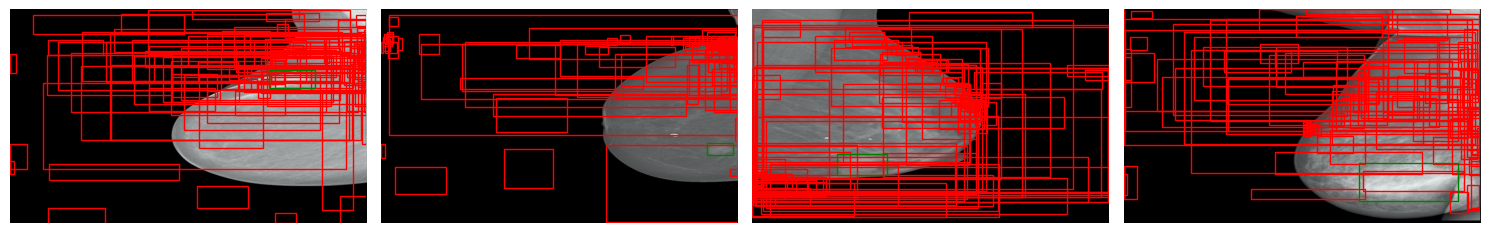

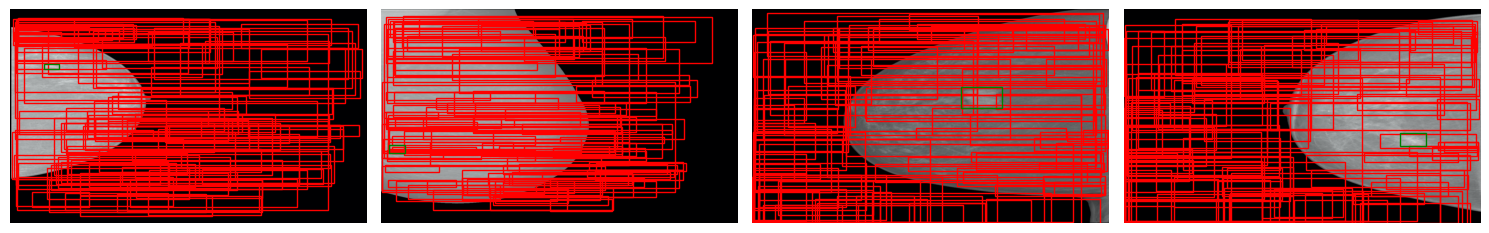

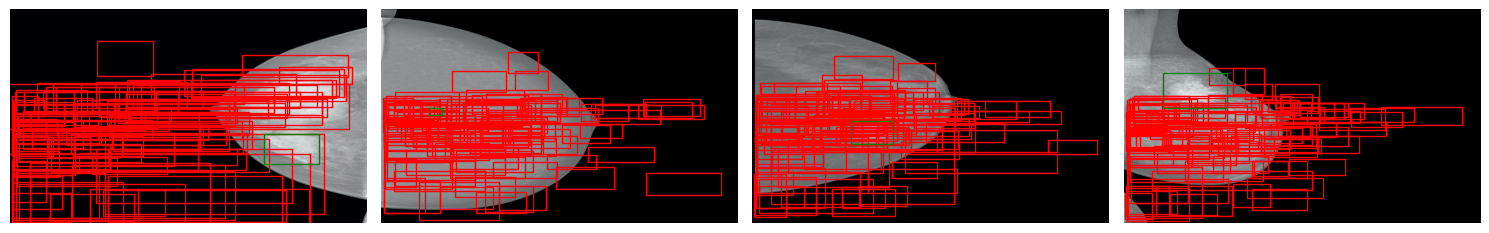

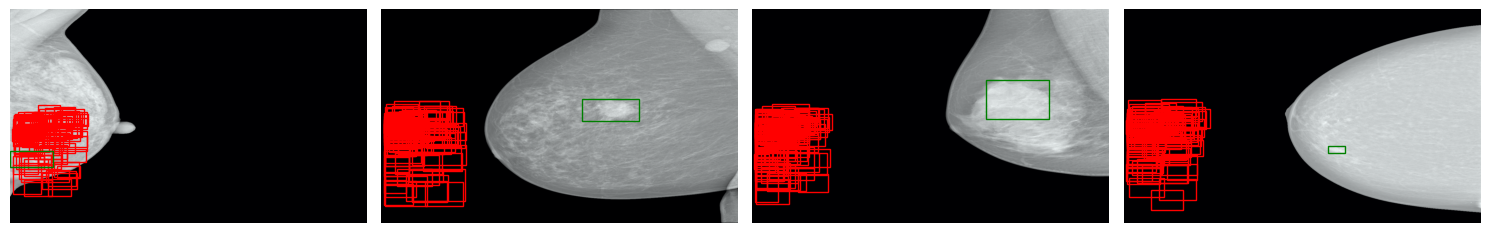

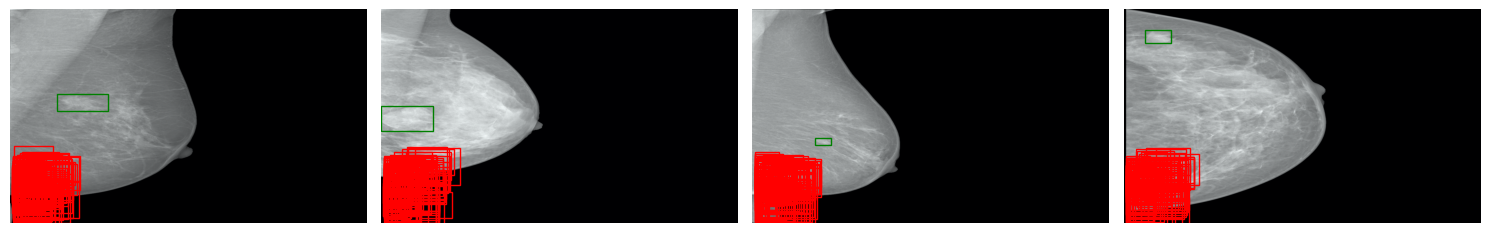

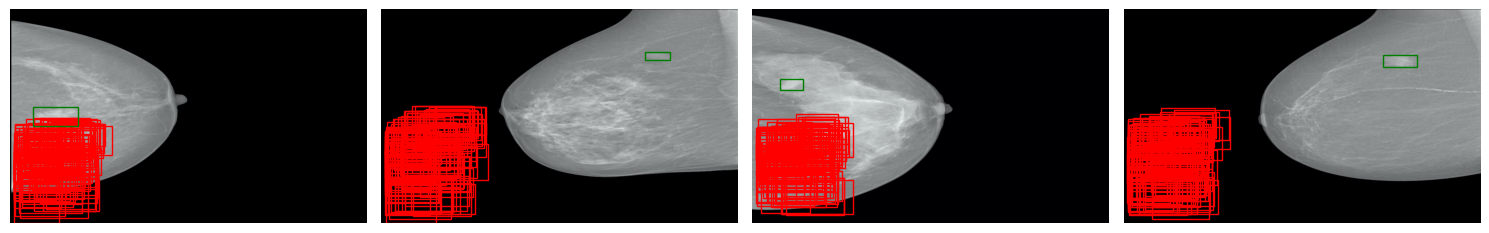

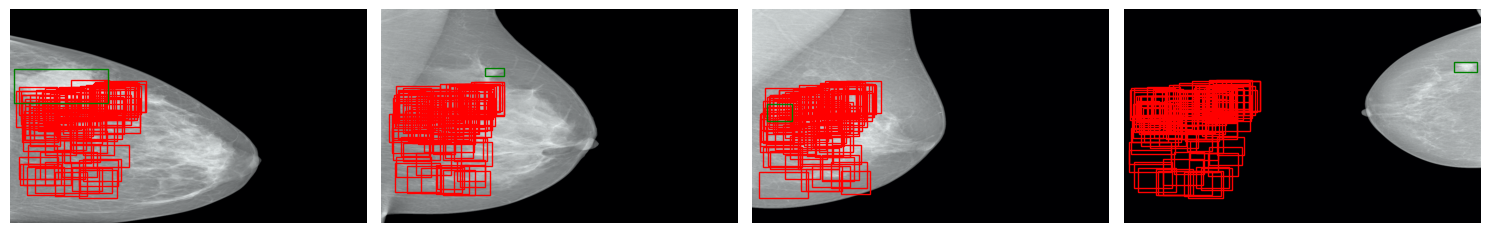

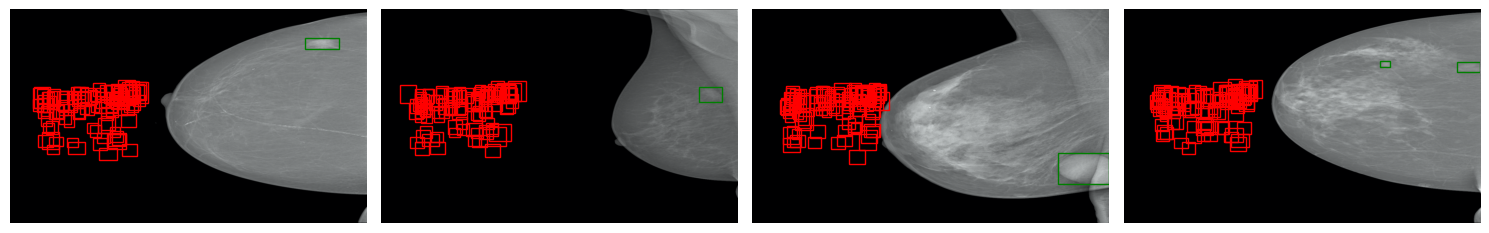

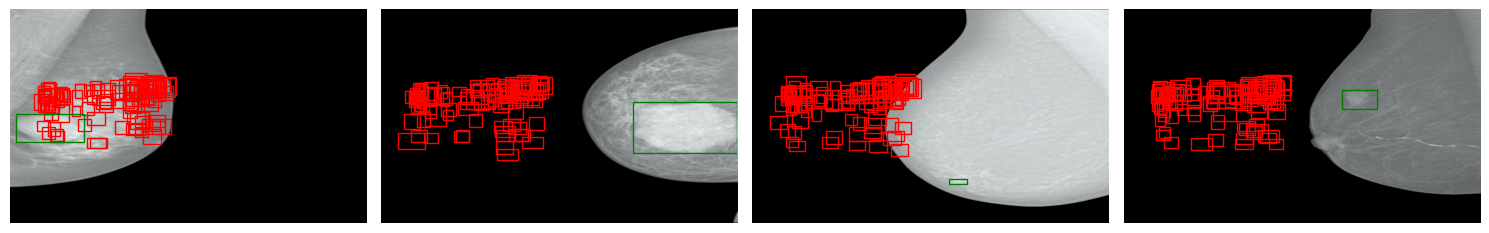

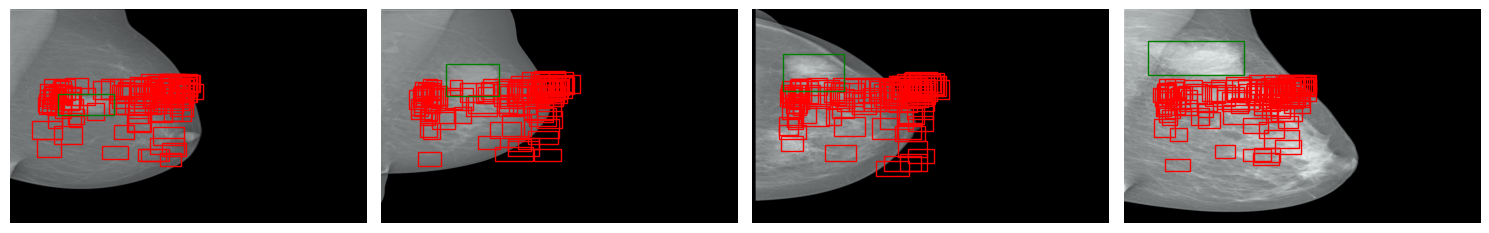

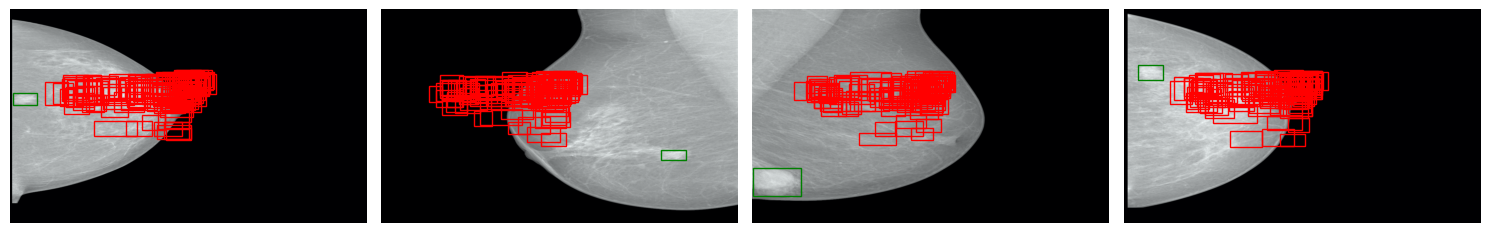

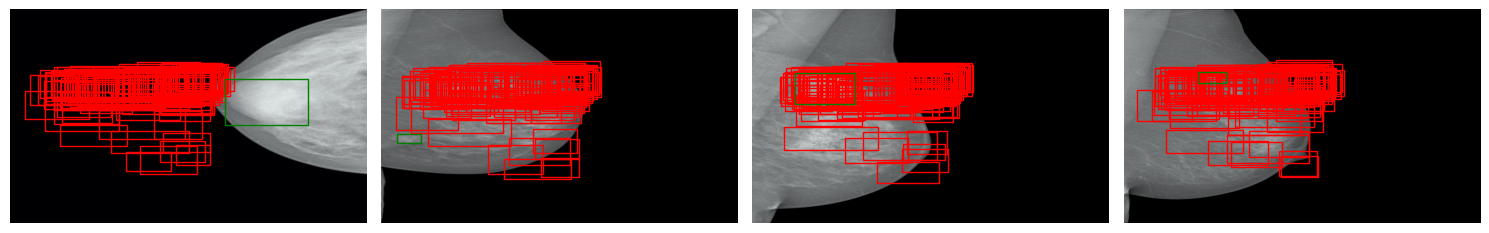

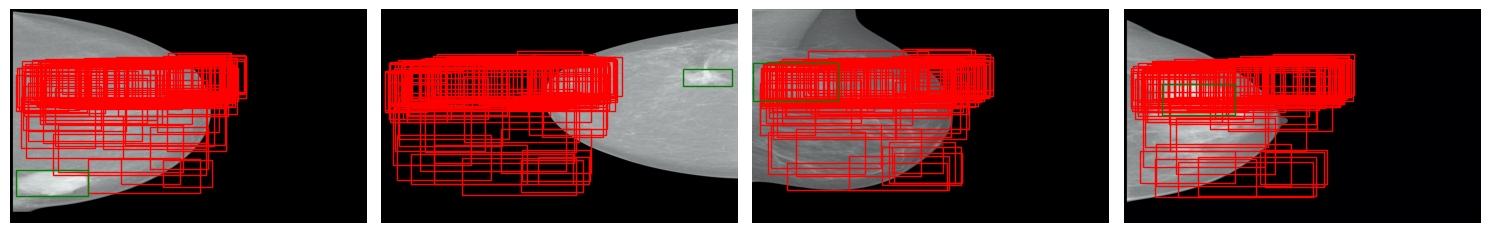

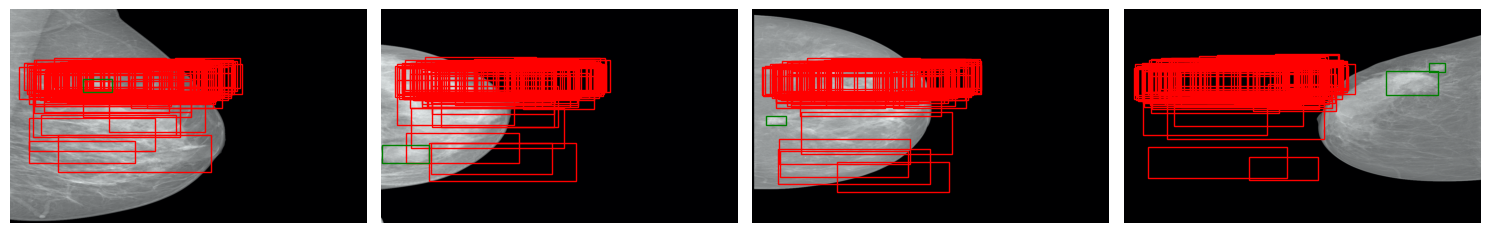

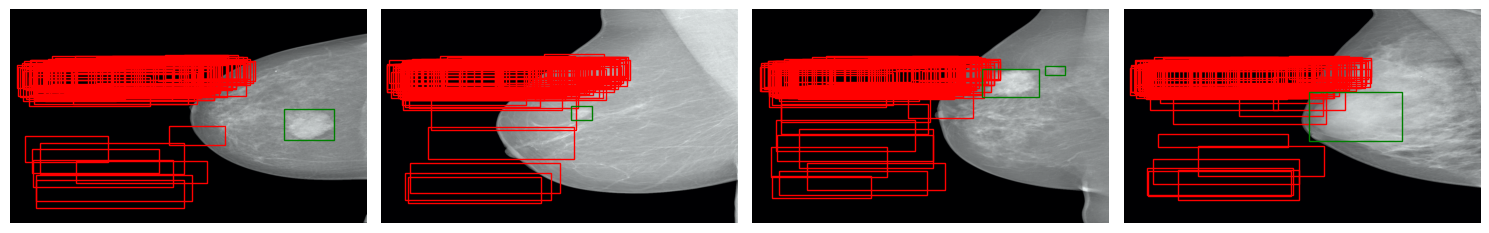

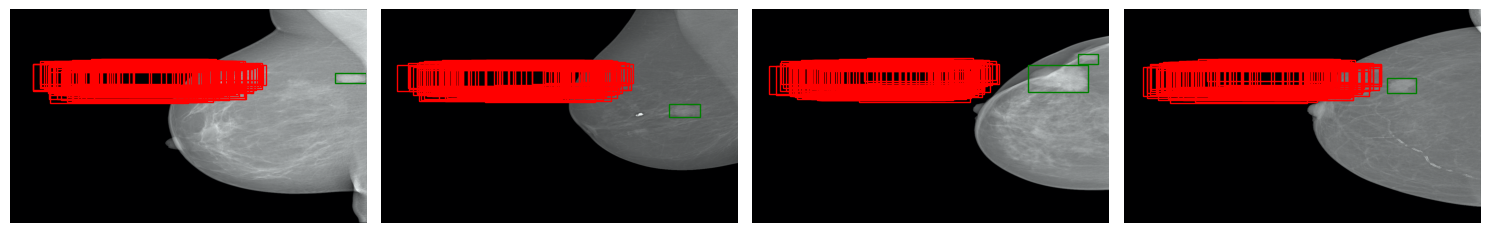

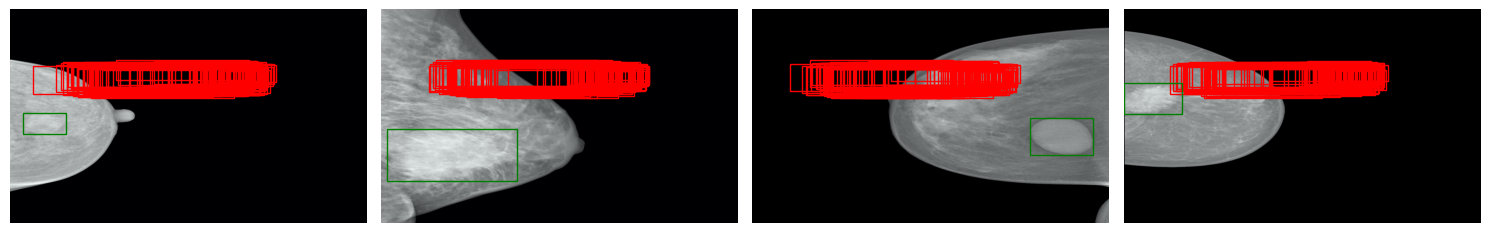

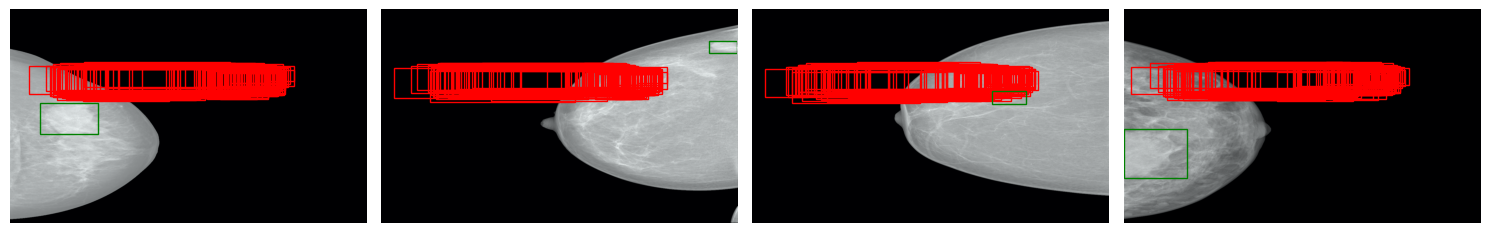

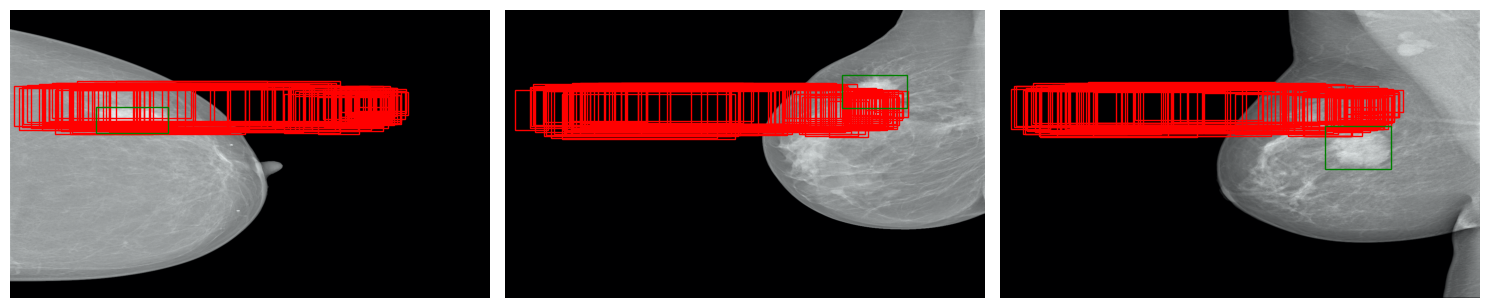

  0%|          | 0/5 [00:00<?, ?it/s]

lr: 0.001
|EPOCH 1| TRAIN_LOSS 5.449910389749627| Train_losses_list [9.233427047729492, 4.956108093261719, 5.544788360595703, 5.8249101638793945, 6.184108734130859, 6.024571418762207, 5.066200256347656, 6.945332050323486, 5.608023643493652, 4.791290283203125, 5.537458419799805, 4.41953706741333, 4.334465026855469, 5.407581806182861, 5.210602283477783, 5.331598281860352, 5.070937633514404, 4.51341438293457, 3.543942451477051]|
|loss_ce 0.34131061089666265| loss_ce_list [0.7890889644622803, 0.33463212847709656, 0.3918253779411316, 0.3383006751537323, 0.3717653155326843, 0.31965404748916626, 0.32063108682632446, 0.35737499594688416, 0.32477831840515137, 0.32388532161712646, 0.3170969486236572, 0.3100414276123047, 0.2964617908000946, 0.33675679564476013, 0.3204975724220276, 0.29690495133399963, 0.2568797469139099, 0.2517824172973633, 0.22654372453689575]|


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

lr: 0.001
|EPOCH 2| TRAIN_LOSS 4.901655899850946| Train_losses_list [4.429281234741211, 3.12851619720459, 3.377336025238037, 5.764897346496582, 4.17172908782959, 4.863752365112305, 5.472437858581543, 5.801352024078369, 6.9269819259643555, 6.22437858581543, 5.587701797485352, 5.096437454223633, 5.172077178955078, 4.629695892333984, 4.049698829650879, 5.711274147033691, 3.5972070693969727, 4.565473556518555, 4.5612335205078125]|
|loss_ce 0.2759688473061511| loss_ce_list [0.24991850554943085, 0.17052973806858063, 0.18176151812076569, 0.2918887734413147, 0.3057418167591095, 0.2833324372768402, 0.34200429916381836, 0.38957446813583374, 0.283548504114151, 0.2812911570072174, 0.2875843346118927, 0.2720607817173004, 0.27468806505203247, 0.22375726699829102, 0.2090567946434021, 0.34867581725120544, 0.2135334610939026, 0.31582319736480713, 0.3186371624469757]|


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

lr: 0.001
|EPOCH 3| TRAIN_LOSS 4.3190108349448755| Train_losses_list [4.575777053833008, 5.5164475440979, 3.8452672958374023, 5.582941055297852, 5.236077308654785, 5.414394378662109, 5.673545837402344, 3.7914717197418213, 2.7442245483398438, 4.291086196899414, 3.9539709091186523, 3.9080986976623535, 3.4568307399749756, 4.352902889251709, 3.002647876739502, 5.332286357879639, 5.15599250793457, 2.8839969635009766, 3.3432459831237793]|
|loss_ce 0.2242324477747867| loss_ce_list [0.31942376494407654, 0.3572728633880615, 0.28732380270957947, 0.33286717534065247, 0.2785281538963318, 0.22230276465415955, 0.18787235021591187, 0.22458085417747498, 0.17309392988681793, 0.21881693601608276, 0.1500832438468933, 0.15741214156150818, 0.1365334689617157, 0.1754622757434845, 0.12873102724552155, 0.3739941716194153, 0.27216026186943054, 0.11375467479228973, 0.1502026468515396]|


In [ ]:
#detr = DETR(num_classes=num_classes, num_queries=num_queries, hidden_dim=hidden_dim, nheads=nheads, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers)
detr = DETR(num_classes=num_classes+1, num_queries=num_queries)
detr = detr.to(device)
train_losses_per_epoch = []
valid_losses_per_epoch = []

# for name, param in detr.named_parameters():
#   if name.startswith('backbone'): #zamrznem parametre za backbone, ako ih ne zamrznem nemam dovoljno memorije za treniranje
#     param.requires_grad = False
#   else:
#     param.requires_grad = True

criterion = SetCriterion(num_classes, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)
optimizer = torch.optim.AdamW(detr.parameters(), lr=LR)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)  # Adjust lr every step_size epoch

best_loss = 10**5
for epoch in range(EPOCHS):

  #train_losses, min_class_error = train(train_dataloader, detr, criterion, optimizer, device, scheduler=scheduler, epoch=epoch)
  train_losses, min_class_error, loss_ce_list, class_error_list, loss_bbox_list, loss_giou_list = train(train_dataloader, detr, criterion, optimizer, device, scheduler=scheduler, epoch=epoch)
  val_losses, min_class_error_v, loss_ce_list_v, class_error_list_v, loss_bbox_list_v, loss_giou_list_v = eval(val_dataloader, detr, criterion, device)

  for param_group in optimizer.param_groups:
    print('lr:', param_group['lr'])

  # update learning rate
  scheduler.step()

  # print('|EPOCH {}| TRAIN_LOSS {}|'.format(epoch+1,loss_dict_list))
  print('|EPOCH {}| TRAIN_LOSS {}| Train_losses_list {}|'.format(epoch+1,np.mean(train_losses),train_losses))
  print('|loss_ce {}| loss_ce_list {}|'.format(np.mean(loss_ce_list),loss_ce_list))
  train_losses_per_epoch.append(np.mean(loss_ce_list))
  valid_losses_per_epoch.append(np.mean(loss_ce_list_v))
  # print('|loss_bbox {}| loss_bbox_list {}|'.format(np.mean(loss_bbox_list),loss_bbox_list))
  # print('|loss_giou {}| loss_giou_list {}|'.format(np.mean(loss_giou_list),loss_giou_list))
  # print('|class_error {}| class_error_list {}|'.format(np.mean(class_error_list),class_error_list))
  #print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))
  #train_losses_per_epoch.append(train_loss.avg)
  #train_losses_per_epoch.append(np.mean(train_losses))
  #valid_losses.append(valid_loss.avg)

  # if valid_loss.avg < best_loss:
  #   best_loss = valid_loss.avg
  #   print('Best model found in Epoch {}........Saving Model'.format(epoch+1))
  #   torch.save(detr.state_dict(), f'detr_best.pth')

In [ ]:
plt.title('Training loss')
plt.plot(train_losses_per_epoch)

In [ ]:
plt.title('Validation loss')
plt.plot(valid_losses_per_epoch)

# Visualize model output

In [ ]:
def view_sample(dataloader,model, pred_type='p'):

  for images, targets in dataloader:
    print('batch size',images.shape[0])
    batch_size = images.shape[0]

    #prediction
    model.eval()
    model.to('cuda')
    cpu_device = torch.device("cpu")
    with torch.no_grad():
      outputs = model(images.to('cuda')) #outpu po batchu

    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]

    fig, axs = plt.subplots(1, batch_size, figsize=(15, 5 * batch_size))  # Podešavanje veličine figure

    if batch_size == 1:
        axs = [axs]

    for ax, image_tensor, target in zip(axs, images, targets):
        # Normalizacija slike za prikaz
        transformed_image = image_tensor.permute(1, 2, 0).cpu().numpy()
        transformed_image = (transformed_image - transformed_image.min()) / (transformed_image.max() - transformed_image.min())

        ax.imshow(transformed_image)

        # Iscrtavanje stvarnih (target) bounding box-ova u zelenoj boji
        target_boxes = target['boxes'].cpu().numpy()
        for target_box in target_boxes:
          norm_cx, norm_cy, norm_w, norm_h = target_box
          img_height, img_width = transformed_image.shape[:2]
          cx = int(norm_cx * img_width)
          cy = int(norm_cy * img_height)
          w = int(norm_w * img_width)
          h = int(norm_h * img_height)
          x = int(cx - w / 2)
          y = int(cy - h / 2)
          rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
          ax.add_patch(rect)

    for output in outputs:
        # print(output)
        pred_boxes = output['pred_boxes'].numpy()[0]
        print(pred_boxes.shape)

        if pred_type == 'p':
          print(output['pred_logits'].shape)
          print('pred_logits',output['pred_logits'])
          #prob   = output['pred_logits'].softmax(1).detach().cpu().numpy()[:,0] #uzima samo za klasu nula verovatnoce
          softmax_scores = torch.softmax(output['pred_logits'], dim=2)
          print('softmax_scores', softmax_scores)
          max_values, max_indices = torch.max(softmax_scores, dim=2)
          #print('max_values',max_values)
          max_values_np = max_values.detach().cpu().numpy()[0]
          print('all prob', max_values_np)
          p_max = max_values_np.max()
          print('p max', p_max)

        for box, p in zip(pred_boxes, max_values_np):
          if p == p_max:
            print(p)
            print(box)
            norm_cx, norm_cy, norm_w, norm_h = box
            cx = int(norm_cx * img_width)
            cy = int(norm_cy * img_height)
            w = int(norm_w * img_width)
            h = int(norm_h * img_height)
            x = int(cx - w / 2)
            y = int(cy - h / 2)
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            break

    plt.show()
    break

In [ ]:
view_sample(train_dataloader, model=detr, pred_type='p')

In [ ]:
torch.save(detr.state_dict(), 'detr_adjusted_loss_weights.pth')